## Data Loading

In [1]:
%pylab inline
import copy

arc = load('mnist.npz')

x_train = arc['arr_0']
y_train = arc['arr_1']
x_test  = arc['arr_2']
y_test  = arc['arr_3']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

size_one = x_train[0].shape

Populating the interactive namespace from numpy and matplotlib
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


**Plotting one image**

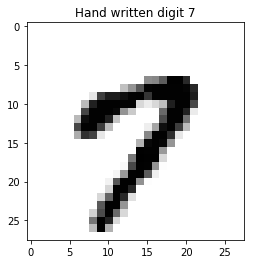

In [2]:
# Show image number 15, and write in the title what digit it should correspond to
def plot_one(N):
    imshow(x_train[N], cmap='gray_r')
    _ = title('Hand written digit '+str(y_train[N]))
plot_one(15)

# Assignment 1

Implement the following distance functions

- d_infty $$ d_{\infty}(a,b) := \max_{i,j} |b_{ij}-a_{ij}|$$
- d_one $$ d_1(a,b) := \sum_{i,j} |b_{ij}-a_{ij}|$$
- d_two $$ d_2(a,b) := \sqrt{\sum_{i,j} |b_{ij}-a_{ij}|^2}$$

that take two `(28,28)` images in input, and return a non-negative number.

In [3]:
def d_infty(a, b):
    return abs(b - a).max()

def d_one(a, b):
    return abs(b - a).sum()

def d_two(a, b):
    return np.sqrt(sum((b - a) ** 2))

# Assignment 2

Write a function that, given a number `N`, and a distance function `dist`, computes the distance matrix D of shape `(N,N)` between the first `N` entries of `x_train`:

```
D[i,j] = dist(x_train[i], x_train[j])
```

performing the **minimum** number of operations (i.e., avoid computing a distance if it has already been computed before, i.e., keep in mind that dist(a,b) = dist(b,a)).

In [4]:
def distance_matrix(N, dist, arr=x_train):
    D = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1):
            D[i, j] = dist(arr[i], arr[j])
    return D + D.transpose()

# Assignment 3

Compute and plot the three distance matrices

- Dinfty
- D1
- D2

for the first 100 images of the training set, using the function `imshow` applied to the three matrices

In [5]:
N = 100

Dinfty = distance_matrix(N, d_infty)
D1 = distance_matrix(N, d_one)
D2 = distance_matrix(N, d_two)

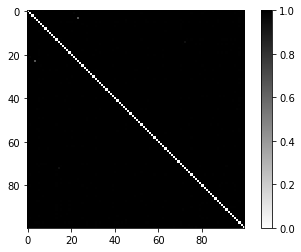

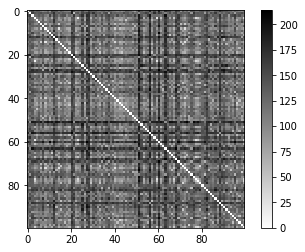

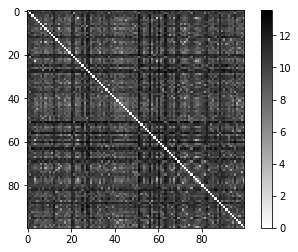

In [6]:
plt.figure()
_ = imshow(Dinfty, cmap='gray_r')
plt.colorbar()
plt.figure()
_ = imshow(D1, cmap='gray_r')
plt.colorbar()
plt.figure()
_ = imshow(D2, cmap='gray_r')
plt.colorbar()

# Assignment 4

Using only a distance matrix, apply the algorithm described above and compute the efficency of the algorithm, i.e., write a function that:

Given a distance matrix with shape `(N,N)`, constructed on the first `N` samples of the `x_train` set, count the number of failures of the **leave one out** strategy, i.e., 

- set `error_counter` to zero

- for every line `i` of the matrix:

    - find the index `j` (different from `i`) for which `D[i,k] >= D[i,j]` for all `k` different from `i` and `j`.

    - if `y_train[j]` is different from `y_train[i]`, increment by one `error_counter`

- return the error: error_counter/N

- apply the function above to the 3 different distance matrices you computed before

In [7]:
def efficiency(D):
    D_copy = copy.deepcopy(D)
    N = D.shape[0]
    np.fill_diagonal(D_copy, inf)
    error_counter = (y_train[D_copy.argmin(axis=0).astype(int)] != y_train[:N]).sum()
    return error_counter / N

In [8]:
print(efficiency(Dinfty))
print(efficiency(D1))
print(efficiency(D2))

0.58
0.17
0.17


# Assignment 5

Run the algorithm implemented above for N=100,200,400,800,1600 on the three different distances, and plot the three error rate as a function of N (i.e., compute the distance matrix, and compute the efficiency associated to the distance matrix).

You should get an error like:
```
[[ 0.58      0.17      0.17    ]
 [ 0.52      0.145     0.135   ]
 [ 0.4425    0.15      0.135   ]
 [ 0.4       0.145     0.12875 ]
 [ 0.369375  0.1025    0.09375 ]]
```
where each column represents a different norm.

In [9]:
Ns = [100, 200, 400, 800, 1600]
Dinfty = distance_matrix(1600, d_infty)
D1 = distance_matrix(1600, d_one)
D2 = distance_matrix(1600, d_two)

In [10]:
err = [[efficiency(D[:n, :n]) for D in [Dinfty, D1, D2]] for n in Ns]
err

[[0.58, 0.17, 0.17],
 [0.52, 0.145, 0.135],
 [0.4425, 0.15, 0.135],
 [0.4, 0.145, 0.12875],
 [0.369375, 0.1025, 0.09375]]

# Assignment 6

In principle, it should be possible to decrease the error by using a better norm. From the table above, it is clear that the L2 distance works better than the L1 distance, which works better than the Linfty distance.

However, *none of these distances exploit the fact that the image is a two-dimensional object*, and that there is information also in the **neighboring** information of the pixels. 

One way to exploit this, is to interpret the image as a continuous function with values between zero and one, defined on a square domain `\Omega=[0,27]x[0,27]`.

$$ f: \Omega \to R $$

- Implement a function that computes an approximation of the $H^1$ norm distance on the renormalized images. Given two images $f_1$ and $f_2$
    - Compute $$a = \frac{f_1}{\int_\Omega f_1}$$, $$b=\frac{f_2}{\int_\Omega f_2}$$
    - Define the $H^1$ distance as
    $$
    d_{H^1}(f_1,f_2) := \sqrt{\int_\Omega |\nabla(a-b)|^2+ (a-b)^2}
    $$
    using the algorithm you prefer (or the library you prefer) to compute the gradients and the integrals. Notice that $\nabla f = (\partial f/\partial x, \partial f/\partial y)$ is a vector valued function, and $|\nabla g|^2 := (\partial g/\partial x)^2 + (\partial g/\partial y)^2$

- Compute the distance matrix and the efficiency for this distance for N=100,200,400,800,1600

In [12]:
from scipy import integrate
from scipy import spatial

In [9]:
def d_h1(a, b):
    a1 = a / integrate.simps(integrate.simps(a))
    b1 = b / integrate.simps(integrate.simps(b))
    return np.sqrt(
        integrate.simps(integrate.simps(
        array(gradient(a1-b1, axis=0)) ** 2 + array(gradient(a1-b1, axis=1)) ** 2 + (a1-b1) ** 2)))

In [10]:
# faster way of computing distance matrix of H1 distance
# exploiting broadcasting features
# however due to a bigger demand of space (RAM) it works
# (on my computer) only up to N=800
def distance_matrix_h1(N): 
    A = integrate.simps(integrate.simps(x_train))
    A = x_train / A[:, None, None]
    A = A[:N, None] - A[:N]
    G = array(gradient(A, axis=-2)) ** 2 + array(gradient(A, axis=-1)) ** 2
    return np.sqrt(integrate.simps(integrate.simps(G + (A ** 2))))

In [15]:
# comparison between both methods for getting the
# distance matrix according to H1 distance
# difference can be seen nad it's quite significant
%timeit distance_matrix(400, d_h1)
%timeit distance_matrix_h1(400)

33.3 s ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.54 s ± 205 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
# D_H1 = distance_matrix_h1(800)
D_H1_big = distance_matrix(1600, d_h1)

In [76]:
Ns = [100, 200, 400, 800, 1600]
err = [efficiency(D_H1_big[:n, :n]) for n in Ns]
err

[0.23, 0.18, 0.15, 0.12, 0.09875]

In [74]:
!top -l 1 -s 0 | grep PhysMem

PhysMem: 4337M used (1766M wired), 3854M unused.


## Assignment 7

An even better improvement on the previous distance function is given by the following algorithm

- Given two images $f1$ and $f2$:
    - Compute $$a = \frac{f_1}{\int_\Omega f_1}$$, $$b=\frac{f_2}{\int_\Omega f_2}$$
    - Solve 
    $$
    -\Delta \phi = a - b \qquad \text{ in } \Omega
    $$
    $$
    \phi = 0 \text{ on } \partial\Omega
    $$
    - Define the *Monge Ampere* distance
    $$
    d_{MA}(f_1,f_2) = \int_\Omega (a+b)|\nabla \phi|^2
    $$

- Compute the distance matrix and the efficiency for this distance for N=100,200,400,800,1600

In [9]:
"""
In order to translate the problem into form B * Fi = a - b,
we need to build the matrix B.
As the matrix is symmetric positive definite, we can speed up
solving the system of linear equations by computing the
Cholesky factorization.
"""

from scipy import linalg

size = x_train.shape[1]

D = diag(2*ones((size,))) - eye(size, k=1) - eye(size, k=-1)
B = kron(D, eye(size)) + kron(eye(size), D)

B_cho = linalg.cho_factor(B)

In [12]:
"""
Define distance in a simple way to be able to reuse
methods from the beginning of the assignment.
"""
def d_ma(a, b):
    a1 = a / integrate.simps(integrate.simps(a))
    b1 = b / integrate.simps(integrate.simps(b))
    fi = linalg.cho_solve(B_cho, (a1-b1).ravel()).reshape(a1.shape)
    return integrate.simps(
        integrate.simps((a1 + b1) * 
                        (array(gradient(fi, axis=0)) ** 2 + array(gradient(fi, axis=1)) ** 2)))

In [10]:
"""
However, we can exploit linearity and there is no need to solve a 
system of linear equations for each pair a - b anymore, but only for 
each image. This means we have to solve a system only n times, 
comparing to n!/(2*(n-2)!) times.
This method also makes use of broadcasting and uses more space,
but it is also faster.
"""
def distance_matrix_ma_br(N):
    A = integrate.simps(integrate.simps(x_train[:N]))
    A = x_train[:N] / A[:, None, None]
    Fi = array([linalg.cho_solve(B_cho, a.ravel()).reshape(x_train[0].shape) for a in A])
    Fi = Fi[:, None] - Fi[:]
    G = gradient(Fi, axis=-2) ** 2 + gradient(Fi, axis=-1) ** 2
    A = A[:, None] + A[:]
    return np.sqrt(integrate.simps(integrate.simps(A * G)))

"""
Too much space in the previous function is used when
performing the gradient over the array of distances.
To improve this we calculate separate gradients
and then combine them into array of distances.
"""
def distance_matrix_ma_br_improved(N):
    A = integrate.simps(integrate.simps(x_train[:N]))
    A = x_train[:N] / A[:, None, None]
    Fi = array([linalg.cho_solve(B_cho, a.ravel()).reshape(x_train[0].shape) for a in A])
    GFix = gradient(Fi, axis=-2)
    GFiy = gradient(Fi, axis=-1)
    G =  (GFiy[:, None] - GFiy[:]) ** 2 + (GFix[:, None] - GFix[:]) ** 2
    A = A[:, None] + A[:]
    return np.sqrt(integrate.simps(integrate.simps(A * G)))

In [14]:
"""
A more naive implementation
without broadcasting but with precomputing things
that can be precomputed and are used repeatedly
"""
def distance_matrix_ma_looped(N):
    A = integrate.simps(integrate.simps(x_train[:N]))
    A = x_train[:N] / A[:, None, None]
    Fi = array([linalg.cho_solve(B_cho, a.ravel()).reshape(x_train[0].shape) for a in A])
    GFix = gradient(Fi, axis=-2)
    GFiy = gradient(Fi, axis=-1)
    D = np.zeros((N, N))
    for i in range(N):
        for j in range(i+1):
            D[i, j] = np.sqrt(integrate.simps(integrate.simps((
                A[i] + A[j]) * 
                ((Fix[i] - Fix[j]) ** 2 +  (Fiy[i] - Fiy[j]) ** 2))))
    return D + D.transpose()

In [51]:
"""
Here, timing of all three methods presented is done
and clearly we can see which one is the fastest
"""
N = 100
%timeit distance_matrix(N, d_ma)
%timeit distance_matrix_ma_looped(N)
%timeit distance_matrix_ma_br(N)
%timeit distance_matrix_ma_br_improved(N)

5.76 s ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
579 ms ± 2.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
278 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
216 ms ± 7.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
"""
Evaluate the method for different N.
"""
N = 800
Ns = [100, 200, 400, 800]
Dma = distance_matrix_ma_br_improved(N)
err = [efficiency(Dma[:n, :n]) for n in Ns]
err

[0.24, 0.195, 0.145, 0.12625]

## Assigment 8 (optional for DSSC, PhD and LM, Mandatory for MHPC)

Use the `BallTree` algorithm (https://en.wikipedia.org/wiki/Ball_tree), from the `sklearn` package, and construct a tree data structure **that uses one of the custom distances defined above**.

For each N in 3200,6400,12800,25600,51200, and for each distance defined above

- Build a tree using the first N entries of the training set `x_train`
- Construct a function that tests the efficiency on all the entries of the test set `x_test`:
    - for any image in `x_test`, call it `x_test[i]`, query the tree for the nearest neighbor (call it `k`), and assign as predicted digit the digit of the `x_train[k]` image, i.e., `y_train[k]`
    - check if `y_train[k]` is equal to the corresponding entry in `y_test[i]`. If not, increment a counter of the error
    - return the efficiency, i.e., `error_counter/len(x_test)`
- Plot, in a single graph, the error of each distance as a function of `N` (including labels, titles, etc.)

- Once you have the tree, experiment with different nearest neighbor algorithms, i.e., instead of taking only one nearest neighbor, take a larger number (a small number of your choice), and instead of returning the single closest digit, return the one with the largest number of occurrences. Plot the same graph you gave before, and see if you gain an improvement. Motivate all choices you have to make to get to the final answer.


**IF YOU DON'T HAVE ENOUGH COMPUTATIONAL POWER, RUN THE EXERCISES ONLY UP TO WHAT IS SUSTAINABLE FOR YOUR PC**

In [8]:
from sklearn.neighbors import BallTree
from scipy import integrate
from scipy import linalg

In [25]:
N = 51200
M = 28
A = integrate.simps(integrate.simps(x_train[:N]))
A = (x_train[:N] / A[:, None, None])
Fi = array([linalg.cho_solve(B_cho, a.ravel()).reshape((M, M)) for a in A])
Gx = gradient(A, axis=-2).reshape((N, M*M))
Gy = gradient(A, axis=-1).reshape((N, M*M))
GFix = gradient(Fi, axis=-2).reshape((N, M*M))
GFiy = gradient(Fi, axis=-1).reshape((N, M*M))
A = A.reshape((N, 28*28))

In [9]:
def d_ma_t(a, b):
    a1 = a / integrate.simps(a)
    b1 = b / integrate.simps(b)
    fi = linalg.cho_solve(B_cho, a1-b1).reshape(28, 28)
    return integrate.simps(
        (a1 + b1) * 
        (gradient(fi, axis=0).ravel() ** 2 + gradient(fi, axis=1).ravel() ** 2))

def d_h1_t(a, b):
    a1 = a / integrate.simps(a)
    b1 = b / integrate.simps(b)
    r = (a1 - b1).reshape(28, 28)
    return np.sqrt(integrate.simps(
        gradient(r, axis=0).ravel() ** 2 + 
        gradient(r, axis=1).ravel() ** 2 + 
        (a1 - b1) ** 2))

In [10]:
Ns = [3200, 6400, 12800, 25600, 51200]
metrics = [{"metric": "minkowski", "p": 1}, {"metric": "minkowski", "p": 2}, {"metric": "chebyshev"}, 
            {"metric": d_h1_t}, {"metric": d_ma_t}]
Xt = x_test.reshape(x_test.shape[0], 28*28)

"""
Build trees.
Trees were later saved with pickle to avoid rebuilding (for possible later reuse)
"""
Trees = [[BallTree(x_train[:N].reshape(N, 28*28), **m) for N in Ns] for m in metrics]

In [ ]:
M = 10000
Err = zeros((5, 5))
for i in range(3):
    for j in range(5):
        # print(i, j)
        _, idxs = Trees[i][j].query(Xt[:M], k=1)
        Err[i, j] = (y_train[idxs.ravel()] != y_test[:M]).sum() / M
        
""" I cleared the output because it was pointless """

In [ ]:
"""
For the other two costum distances predicting on 10000 was way too slow
so I used only 100 randomly chosen samples among the testing set
"""
M = 100
Midxs = choice(Xt.shape[0], M)
for i in range(3, 5):
    for j in range(5):
        # print(i, j)
        _, idxs = Trees[i][j].query(Xt[Midxs], k=1)
        Err[i, j] = (y_train[idxs.ravel()] != y_test[Midxs]).sum() / M
"""
It was still too slow for the two biggest trees and the 
Monge Ampere distance.. so I killed it.
... and cleared the output
"""

In [63]:
print(Err)

[[0.0908 0.0745 0.0591 0.0484 0.0394]
 [0.0783 0.0631 0.049  0.0402 0.0329]
 [0.3704 0.309  0.2624 0.2261 0.1833]
 [0.04   0.04   0.01   0.01   0.02  ]
 [0.1    0.06   0.05   0.     0.    ]]


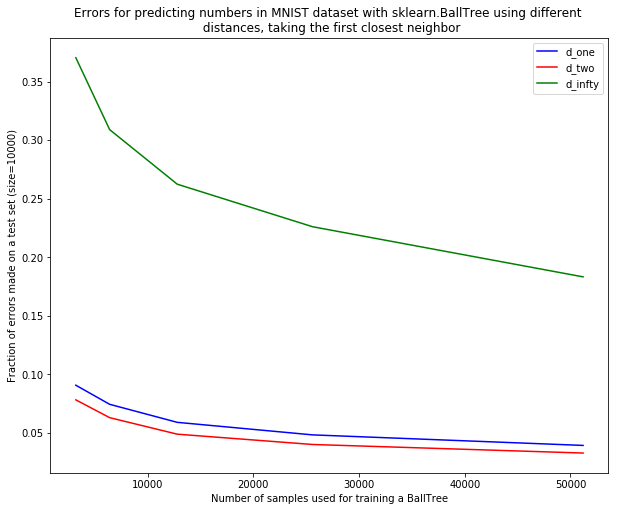

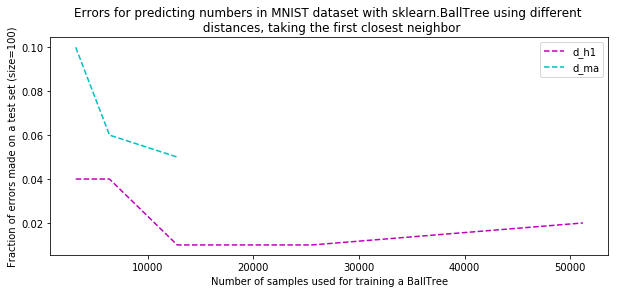

In [85]:
fig = figure(figsize=(10, 8))
title("Errors for predicting numbers in MNIST dataset with sklearn.BallTree using different \n distances, taking the first closest neighbor")
ylabel("Fraction of errors made on a test set (size=10000)")
xlabel("Number of samples used for training a BallTree")
plot(Ns, Err[0], "b", label="d_one")
plot(Ns, Err[1], "r", label="d_two")
plot(Ns, Err[2], "g", label="d_infty")
_ = legend()
fig = figure(figsize=(10, 4))
title("Errors for predicting numbers in MNIST dataset with sklearn.BallTree using different \n distances, taking the first closest neighbor")
ylabel("Fraction of errors made on a test set (size=100)")
xlabel("Number of samples used for training a BallTree")
plot(Ns, Err[3], "m--", label="d_h1")
plot(Ns[:3], Err[4][:3], "c--", label="d_ma")
_ = legend()

In [96]:
"""
Exploring how taking the most common in k closest neighbors affects the
results. Due to computational complexity, only first three distances are
considered. Only the biggest tree is used.
"""
from scipy import stats
M = 10000
Errs_k = zeros((3, 5))
for i in range(3):
    # print(i)
    _, idxs = Trees[i][4].query(Xt[:M], k=100)
    for ik, k in enumerate([1, 10, 20, 50, 100]):
        res = array([y_train[a.ravel()][:k] for a in idxs])
        res_common = stats.mode(res, axis=-1)[0]
        Errs_k[i, ik] = (res_common.ravel() != y_test[:M]).sum() / M

0
1
2


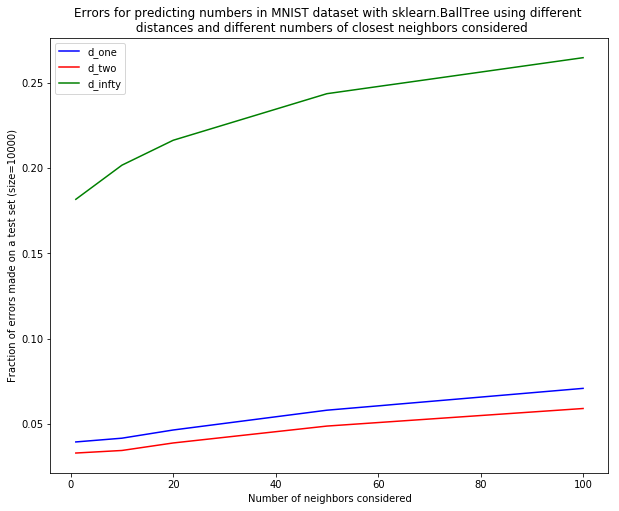

In [99]:
ks = [1, 10, 20, 50, 100]
fig = figure(figsize=(10, 8))
title("Errors for predicting numbers in MNIST dataset with sklearn.BallTree using different \n distances and different numbers of closest neighbors considered")
ylabel("Fraction of errors made on a test set (size=10000)")
xlabel("Number of neighbors considered")
plot(ks, Errs_k[0], "b", label="d_one")
plot(ks, Errs_k[1], "r", label="d_two")
plot(ks, Errs_k[2], "g", label="d_infty")
_ = legend()
"""
We can see that taking more neighbors doesn't improve our predictions.
On the contrary, the more neighbors we consider the worse our predictions
are.
"""